(particion_partes_iguales_grafo)=
# Introducción

En este ejemplo lo que se pretende es dividir los nodos de un grafo en dos conjuntos de igual tamaño, de manera que los arcos entre estos dos conjuntos sean los menos posibles. También se puede resolver utilizando DQM como se puede ver en [el contenido que hay detrás de este enlace](particionGraficoDQM).

Comenzamos cargando los módulos que vamos a necesitar

In [1]:
from dimod import BinaryQuadraticModel
from dimod import ExactSolver
from neal import SimulatedAnnealingSampler
from itertools import combinations
import networkx as nx

## Creación del grafo.

Vamos a crear un grafo muy simple para comprobar que al final la solución obtenida es la que estamos buscando. Los condicionantes con los que vamos a trabajar son los siguientes:

* Creamos un grafo con 6 nodos

* Lo dividimos en dos conjuntos

* Cada conjunto tendrá 6 nodos

* La solución sólo va a tener un arco que conecta los dos conjuntos de nodos.

Construimos el grafo y lo dibujamos por pantalla

In [2]:
edges = [(1, 2), (2, 3), (1, 3), (4, 5), (5, 6), (4, 6), (2, 4)]
nodes = sorted(set().union(*edges))
graph = nx.Graph(edges)

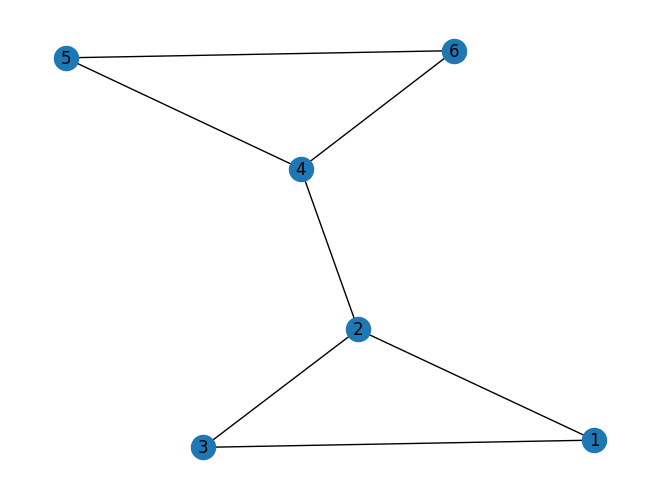

In [3]:
nx.draw(graph, with_labels=True)

## Cración del objeto BQM.

Construimos las variables binarias $x_i$ de tal manera que vale 1 si el nodo i pertenece al primer conjunto y vale cero si pernece al segundo conjunto.

Vamos a construir una función objetivo, y para ello tenemos en cuenta lo siguiente:

Dados dos nodos, o lo que es lo mismo dos variables binarias x e y, se les deberá asignar energia cero si tienen igual valor ( porque eso quiere decir que están en el mismo grupo), y energía máxima 1 si tienen valores diferentes (porque eso quiere decir que están en grupos diferentes). Expreseamos esto mediante la siguiente tabla de la verdad:


x | y | quadratic bias
:----:|:---:|:----:
0   | 0   | 0
0   | 1   | 1
1   | 0   | 1
1   | 1   | 0

La forma cuadrática que buscamos tiene la siguiente representación genérica:

$$ ax+by+cxy+d $$

* si x=y=0 (primera linea tabla de la verdad)  entonces se tiene $a \cdot 0 +b \cdot 0+c \cdot 0 \cdot 0 + d=0 $, luego d=0

* si x=0, y=1 (segunda fila tabla de la verdad). Razonando como antes, se tiene que b=1

* si x=1, y=0 (tercera linea tabla de la verdad). Razonando como antes, se tiene que a=1

* POr último de la cuarta fila de la tabla de la verdad se tiene que c=2

Por lo tanto, al final la ecuación que se obtiene (para cada nodo del grafo formado) es la siguiente:

$$x + y- 2 x y$$

Esta ecuación es aditiva, podemos recorrer cada arista del grafo y sumar al objetivo, por lo que se obtendrá lo siguiente:

$$ E =\sum_{i, j \in Edges} (x_i + x_j - 2 x_i x_j) 

A continuación procedemos a modelizar mediante programación QUBO todo esto.

In [4]:
bqm = BinaryQuadraticModel('BINARY')

x = [bqm.add_variable(node) for node in nodes]
n = len(x)
for a, b in edges:
    bqm.add_variable(a, 1)
    bqm.add_variable(b, 1)
    bqm.add_interaction(a, b, -2)


Veamos en concreto el modelo que se obtiene

In [5]:
bqm

BinaryQuadraticModel({1: 2.0, 2: 3.0, 3: 2.0, 4: 3.0, 5: 2.0, 6: 2.0}, {(2, 1): -2.0, (3, 1): -2.0, (3, 2): -2.0, (4, 2): -2.0, (5, 4): -2.0, (6, 4): -2.0, (6, 5): -2.0}, 0.0, 'BINARY')

## Restricción

Añadimos la siguiente restricción para asegurarnos de que el número de nodos en cada conjunto es el mismo:

$$ \sum_i x_i = \sum_i (1 - x_i) $$

Reagrupando términos se llega a la siguiente condición: 

$$ \sum_i 2 x_i - n = 0$$

donde $n$ es el número de nodos $n = \sum_i 1$

Añadimos esta restricción al modelo BQM anterior.

In [6]:
bqm.add_linear_equality_constraint(
    [(x[i], 2.0) for i in range(n)],
    constant=-n,
    lagrange_multiplier=10
)

Resolvemos con ExactSolver

In [7]:
print(ExactSolver().sample(bqm).truncate(5))

   1  2  3  4  5  6 energy num_oc.
0  0  0  0  1  1  1    1.0       1
1  1  1  1  0  0  0    1.0       1
2  1  0  1  0  1  0    4.0       1
3  0  0  1  0  1  1    4.0       1
4  1  0  0  0  1  1    4.0       1
['BINARY', 5 rows, 5 samples, 6 variables]


## Partición del grafo en más de dos conjuntos.

Pretendemos ahora hacer algo similar al caso anterior, pero para más de dos grupos de nodos. Construimos el grafo siguiente para trabajar con él.

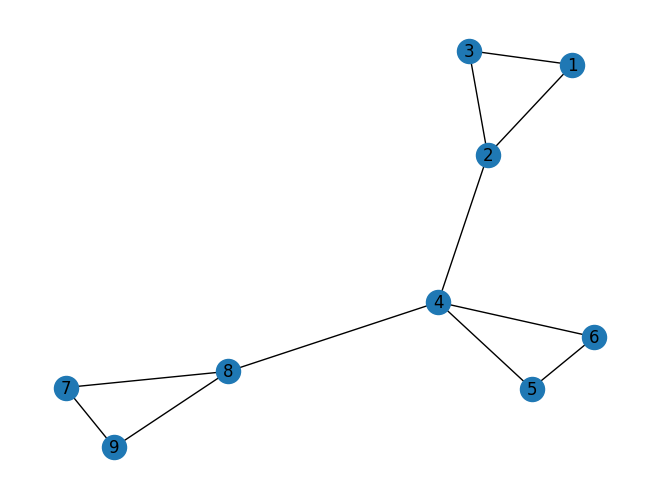

In [8]:
edges = [
    (1, 2), (2, 3), (1, 3), 
    (4, 5), (5, 6), (4, 6), 
    (7, 8), (8, 9), (7, 9),
    (2, 4), (4, 8)
]
nodes = sorted(set().union(*edges))
graph = nx.Graph(edges)
nx.draw(graph, with_labels=True)

## Variables de decisión.

Ahora vamos a construir una variable binaria, pero en este caso con dos subíndices $x_{i,k}$ para cada nodo $i$ y conjunto $k$. Si el valor es uno el nodo $i$ va a estar en el grupo $k$.

El modelo que construimos es el siguiente:

In [9]:
bqm = BinaryQuadraticModel('BINARY')

m = 3
n = len(nodes)
x = {(node, k): bqm.add_variable((f'x_{node}', k))
     for node in nodes
     for k in range(m)}

In [10]:
bqm

BinaryQuadraticModel({('x_1', 0): 0.0, ('x_1', 1): 0.0, ('x_1', 2): 0.0, ('x_2', 0): 0.0, ('x_2', 1): 0.0, ('x_2', 2): 0.0, ('x_3', 0): 0.0, ('x_3', 1): 0.0, ('x_3', 2): 0.0, ('x_4', 0): 0.0, ('x_4', 1): 0.0, ('x_4', 2): 0.0, ('x_5', 0): 0.0, ('x_5', 1): 0.0, ('x_5', 2): 0.0, ('x_6', 0): 0.0, ('x_6', 1): 0.0, ('x_6', 2): 0.0, ('x_7', 0): 0.0, ('x_7', 1): 0.0, ('x_7', 2): 0.0, ('x_8', 0): 0.0, ('x_8', 1): 0.0, ('x_8', 2): 0.0, ('x_9', 0): 0.0, ('x_9', 1): 0.0, ('x_9', 2): 0.0}, {}, 0.0, 'BINARY')

## Objectivo

En lugar de penalizar dos nodos que no están en el mismo conjunto, recompensamos si

* dos nodos pertenecen al mismo conjunto, y

* los dos nodos están conectados


In [11]:
for a, b in edges:
    for k in range(m):
        bqm.add_interaction(x[a, k], x[b, k], -1)   

In [12]:
bqm

BinaryQuadraticModel({('x_1', 0): 0.0, ('x_1', 1): 0.0, ('x_1', 2): 0.0, ('x_2', 0): 0.0, ('x_2', 1): 0.0, ('x_2', 2): 0.0, ('x_3', 0): 0.0, ('x_3', 1): 0.0, ('x_3', 2): 0.0, ('x_4', 0): 0.0, ('x_4', 1): 0.0, ('x_4', 2): 0.0, ('x_5', 0): 0.0, ('x_5', 1): 0.0, ('x_5', 2): 0.0, ('x_6', 0): 0.0, ('x_6', 1): 0.0, ('x_6', 2): 0.0, ('x_7', 0): 0.0, ('x_7', 1): 0.0, ('x_7', 2): 0.0, ('x_8', 0): 0.0, ('x_8', 1): 0.0, ('x_8', 2): 0.0, ('x_9', 0): 0.0, ('x_9', 1): 0.0, ('x_9', 2): 0.0}, {(('x_2', 0), ('x_1', 0)): -1.0, (('x_2', 1), ('x_1', 1)): -1.0, (('x_2', 2), ('x_1', 2)): -1.0, (('x_3', 0), ('x_1', 0)): -1.0, (('x_3', 0), ('x_2', 0)): -1.0, (('x_3', 1), ('x_1', 1)): -1.0, (('x_3', 1), ('x_2', 1)): -1.0, (('x_3', 2), ('x_1', 2)): -1.0, (('x_3', 2), ('x_2', 2)): -1.0, (('x_4', 0), ('x_2', 0)): -1.0, (('x_4', 1), ('x_2', 1)): -1.0, (('x_4', 2), ('x_2', 2)): -1.0, (('x_5', 0), ('x_4', 0)): -1.0, (('x_5', 1), ('x_4', 1)): -1.0, (('x_5', 2), ('x_4', 2)): -1.0, (('x_6', 0), ('x_4', 0)): -1.0, (('x_

## Restricciones

El tamaño de cada conjunto es n/m
- n es el número de nodos
- m es el número de conjuntos

In [13]:
for k in range(m):
    bqm.add_linear_equality_constraint(
        [(x[i, k], 1.0) for i in nodes],
        constant=-n/m,
        lagrange_multiplier=10
    )    

Cada nodo sólo pertence a un conjunto

In [14]:
for node in nodes:
    bqm.add_linear_equality_constraint(
        [(x[node, k], 1.0) for k in range(m)],
        constant=-1.0,
        lagrange_multiplier=10
    )

In [15]:
res = SimulatedAnnealingSampler().sample(bqm, num_reads=100, num_sweeps=10000).truncate(3)
print(res)

  ('x_1', 0) ('x_1', 1) ('x_1', 2) ('x_2', 0) ... ('x_9', 2) energy num_oc.
0          0          1          0          0 ...          0   -9.0       1
1          1          0          0          1 ...          0   -9.0       1
2          0          0          1          0 ...          0   -9.0       1
['BINARY', 3 rows, 3 samples, 27 variables]


In [16]:
assignment = ({variable: set_assignment for (variable, set_assignment), v in res.first.sample.items() if v})
print(assignment)

{'x_1': 1, 'x_2': 1, 'x_3': 1, 'x_4': 2, 'x_5': 2, 'x_6': 2, 'x_7': 0, 'x_8': 0, 'x_9': 0}


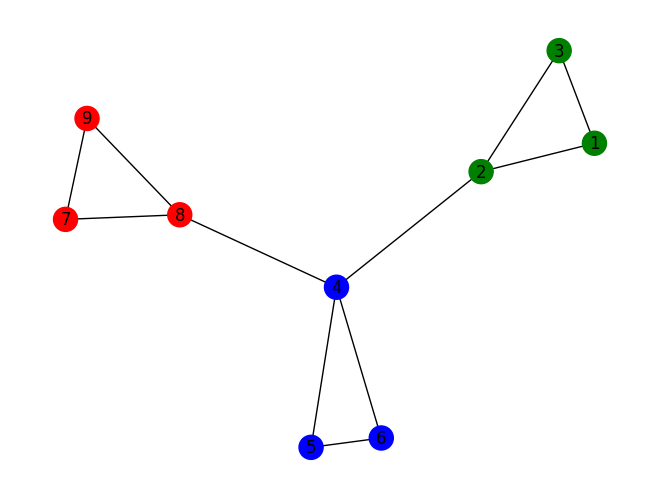

In [17]:
colors = ['r', 'g', 'b']
color_map = [colors[assignment[f'x_{i}']] for i in nodes]   
nx.draw(graph, node_color=color_map, with_labels=True)